# Investigate the raw data from database (mimic-iv)

In [1]:
import getpass
import json
import math
import os
import psycopg2
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from configobj import ConfigObj
from multiprocessing import Pool, RLock
from tqdm import tqdm
from typing import Tuple

from projects.data_cleaning import *
from projects.common import *


## Connect to database.

In [2]:
db_dir = os.path.abspath('') + "/../../../db"

(query_schema_core,
 query_schema_hosp,
 query_schema_icu,
 query_schema_derived,
 conn) = connect_to_database(db_dir)


Database: mimiciv
Username: mimiciv
>>>>> Connected to DB <<<<<


## Inspect transfers table.

In [3]:
transfers_df = get_database_table_as_dataframe(conn, query_schema_core, 'transfers')
transfers_df = transfers_df.dropna()
print(f"Number of entries for transfers with valid care units : {len(transfers_df)}")
print(f"Column names : {transfers_df.columns.tolist()}")

Getting transfers data
Number of entries for transfers : 2189535
Column names : ['subject_id', 'hadm_id', 'transfer_id', 'eventtype', 'careunit', 'intime', 'outtime']
Number of entries for transfers with valid care units : 1255585
Column names : ['subject_id', 'hadm_id', 'transfer_id', 'eventtype', 'careunit', 'intime', 'outtime']


In [4]:
# includes both ICU and wards
careunits = transfers_df[['careunit']].to_numpy()
print(f"Care unit types :")
for i in np.unique(careunits).tolist():
    print(i)

Care unit types :
Cardiac Surgery
Cardiac Vascular Intensive Care Unit (CVICU)
Cardiology
Cardiology Surgery Intermediate
Coronary Care Unit (CCU)
Emergency Department
Emergency Department Observation
Hematology/Oncology
Hematology/Oncology Intermediate
Labor & Delivery
Med/Surg
Med/Surg/GYN
Med/Surg/Trauma
Medical Intensive Care Unit (MICU)
Medical/Surgical (Gynecology)
Medical/Surgical Intensive Care Unit (MICU/SICU)
Medicine
Medicine/Cardiology
Medicine/Cardiology Intermediate
Neonatal Intensive Care Unit (NICU)
Neuro Intermediate
Neuro Stepdown
Neuro Surgical Intensive Care Unit (Neuro SICU)
Neurology
Nursery - Well Babies
Observation
Obstetrics (Postpartum & Antepartum)
Obstetrics Antepartum
Obstetrics Postpartum
PACU
Psychiatry
Special Care Nursery (SCN)
Surgery
Surgery/Pancreatic/Biliary/Bariatric
Surgery/Trauma
Surgery/Vascular/Intermediate
Surgical Intensive Care Unit (SICU)
Thoracic Surgery
Transplant
Trauma SICU (TSICU)
Unknown
Vascular


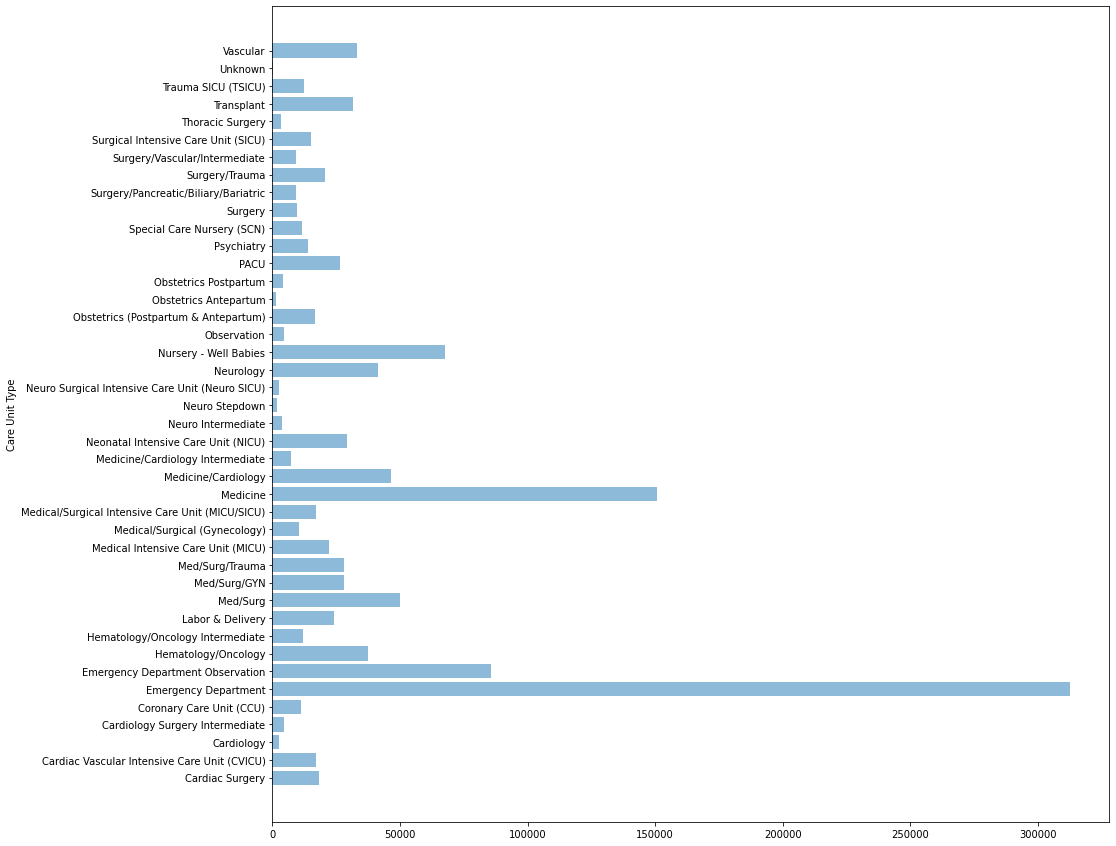

In [5]:
vals, counts = np.unique(careunits[:, 0], return_counts=True)
y_pos = np.arange(len(vals))

plt.figure(figsize=(15, 15))
plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, vals)
plt.ylabel('Care Unit Type')
plt.show()


In [6]:
del transfers_df, careunits

## Inspect ICU schema.

### Inspect icustays table.

In [7]:
icustays_df = get_database_table_as_dataframe(conn, query_schema_icu, 'icustays')
careunits = icustays_df[['first_careunit', 'last_careunit']].to_numpy()
print(f"Care unit types :")
for i in np.unique(careunits).tolist():
    print(i)


Getting icustays data
Number of entries for icustays : 76540
Column names : ['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los']
Care unit types :
Cardiac Vascular Intensive Care Unit (CVICU)
Coronary Care Unit (CCU)
Medical Intensive Care Unit (MICU)
Medical/Surgical Intensive Care Unit (MICU/SICU)
Neuro Intermediate
Neuro Stepdown
Neuro Surgical Intensive Care Unit (Neuro SICU)
Surgical Intensive Care Unit (SICU)
Trauma SICU (TSICU)


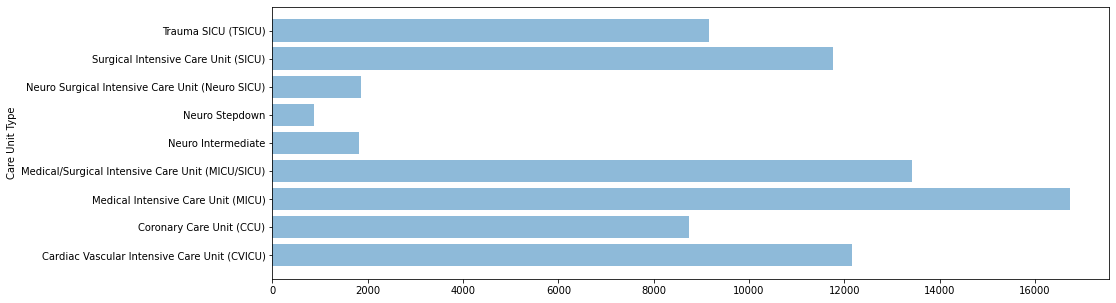

In [8]:
vals, counts = np.unique(careunits[:, 0], return_counts=True)
y_pos = np.arange(len(vals))

plt.figure(figsize=(15, 5))
plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, vals)
plt.ylabel('Care Unit Type')
plt.show()


In [9]:
del icustays_df, careunits

### Inspect itemid

In [10]:
d_items_df = get_database_table_as_dataframe(conn, query_schema_icu, 'd_items')
d_items_df

Getting d_items data
Number of entries for d_items : 3861
Column names : ['itemid', 'label', 'abbreviation', 'linksto', 'category', 'unitname', 'param_type', 'lownormalvalue', 'highnormalvalue']


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,None,Date and time,NaN,NaN
1,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
2,220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,NaN,NaN
3,220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,NaN,NaN
4,220048,Heart Rhythm,Heart Rhythm,chartevents,Routine Vital Signs,None,Text,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3856,229355,Absolute Neutrophil Count,Absolute Neutrophil Count,chartevents,Labs,None,Numeric,NaN,NaN
3857,229453,Exam-GI/GU,Exam-GI/GU,chartevents,MD Progress Note,None,Text,NaN,NaN
3858,229604,Therapeutic Bed,Therapeutic Bed,chartevents,Treatments,None,Text,NaN,NaN
3859,229709,Angiotensin II (Giapreza),Angiotensin II (Giapreza),inputevents,Medications,mg,Solution,NaN,NaN


### Itemid will only show up in one of the events tables. There can be multiple instances in one of the tables.

In [11]:
procedureevents_df = get_database_table_as_dataframe(conn, query_schema_icu, 'procedureevents', 'itemid', 1000)
outputevents_df = get_database_table_as_dataframe(conn, query_schema_icu, 'outputevents', 'itemid', 1000)
inputevents_df = get_database_table_as_dataframe(conn, query_schema_icu, 'inputevents', 'itemid', 1000)
datetimeevents_df = get_database_table_as_dataframe(conn, query_schema_icu, 'datetimeevents', 'itemid', 1000)

def _concat_df_chunk(df_iter):
    dfs_ = []
    for df in tqdm(df_iter):
        dfs_ += [df[['itemid']].to_numpy()]
    return np.concatenate(dfs_, axis=0)

procedureevents_id = _concat_df_chunk(procedureevents_df)
outputevents_id = _concat_df_chunk(outputevents_df)
inputevents_id = _concat_df_chunk(inputevents_df)
datetimeevents_id = _concat_df_chunk(datetimeevents_df)

assert ~np.isin(np.unique(procedureevents_id), np.unique(outputevents_id)).any()
assert ~np.isin(np.unique(procedureevents_id), np.unique(inputevents_id)).any()
assert ~np.isin(np.unique(procedureevents_id), np.unique(datetimeevents_id)).any()
assert ~np.isin(np.unique(outputevents_id), np.unique(inputevents_id)).any()
assert ~np.isin(np.unique(outputevents_id), np.unique(datetimeevents_id)).any()
assert ~np.isin(np.unique(inputevents_id), np.unique(datetimeevents_id)).any()

Getting procedureevents data


732it [00:01, 411.50it/s]


Number of entries for procedureevents : 731247
Column names : ['itemid']
Getting outputevents data


4458it [00:03, 1202.37it/s]


Number of entries for outputevents : 4457381
Column names : ['itemid']
Getting inputevents data


9461it [00:11, 858.96it/s] 


Number of entries for inputevents : 9460658
Column names : ['itemid']
Getting datetimeevents data


7496it [00:07, 1045.54it/s]


Number of entries for datetimeevents : 7495712
Column names : ['itemid']


732it [00:01, 524.53it/s]
4458it [00:07, 599.11it/s]
9461it [00:14, 657.43it/s]
7496it [00:11, 658.21it/s]


In [12]:
del procedureevents_df, outputevents_df, inputevents_df, datetimeevents_df
del procedureevents_id, outputevents_id, inputevents_id, datetimeevents_id

In [ ]:
# chartevents_df = get_database_table_as_dataframe(conn, query_schema_icu, 'chartevents', 'itemid', 1000)

In [ ]:

# chartevents_df = get_database_table_as_dataframe(conn, query_schema_icu, 'chartevents', 'itemid', 10000)
# datetimeevents_df = get_database_table_as_dataframe(conn, query_schema_icu, 'datetimeevents', 'itemid', 10000)
# inputevents_df = get_database_table_as_dataframe(conn, query_schema_icu, 'inputevents', 'itemid', 10000)
# outputevents_df = get_database_table_as_dataframe(conn, query_schema_icu, 'outputevents', 'itemid', 10000)
# procedureevents_df = get_database_table_as_dataframe(conn, query_schema_icu, 'procedureevents', 'itemid', 10000)

In [ ]:
# overall_itemid_list = d_items_df[['itemid']].to_numpy()
# concated_itemid_list = np.concatenate([
#     chartevents_df[['itemid']].to_numpy(),
#     datetimeevents_df[['itemid']].to_numpy(),
#     inputevents_df[['itemid']].to_numpy(),
#     outputevents_df[['itemid']].to_numpy(),
#     procedureevents_df[['itemid']].to_numpy()], axis=0)